# Exploratory Data Analysis

## Content
- [Import Necessary Modules and Dataset](#import&data)
- [Assess the Relationships of Texts Using Heatmap](#relationAS)
- [Empirical Cumulative Distribution Function](#ecdf)
- [Permutation Test: Score With 'pneumococcal' and Without 'pneumococcal'](#hypothesis)
- [Summary](#summary)

### Import Necessary Modules and Datasets <a id = 'import&data'></a>

In [111]:
# Import tools to get datasets
from io import BytesIO
from zipfile import ZipFile
import urllib

# Import data manipulation and plot modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Import NLP tools
from sklearn.feature_extraction.text import TfidfVectorizer

In [112]:
## Unzip and read Q1
url = urllib.request.urlopen('https://github.com/jonahwinninghoff/Springboard_Capstone_Project/raw/main/Assets/neat_Q1_score_data.zip')
file = ZipFile(BytesIO(url.read()))
q1file = file.open("neat_Q1_score_data")
q1 = pd.read_json(q1file, encoding='cp1252')
file.close()

In [113]:
# Unzip and read Q2
url = urllib.request.urlopen('https://github.com/jonahwinninghoff/Springboard_Capstone_Project/raw/main/Assets/neat_Q2_score_data.zip')
file = ZipFile(BytesIO(url.read()))
q2file = file.open("neat_Q2_score_data")
q2 = pd.read_json(q2file, encoding='cp1252')
file.close()

In [114]:
# Unzip and read Q3
url = urllib.request.urlopen('https://github.com/jonahwinninghoff/Springboard_Capstone_Project/raw/main/Assets/neat_Q3_score_data.zip')
file = ZipFile(BytesIO(url.read()))
q3file = file.open("neat_Q3_score_data")
q3 = pd.read_json(q3file, encoding='cp1252')
file.close()

In [115]:
# Unzip and read Q4
url = urllib.request.urlopen('https://github.com/jonahwinninghoff/Springboard_Capstone_Project/raw/main/Assets/neat_Q4_score_data.zip')
file = ZipFile(BytesIO(url.read()))
q4file = file.open("neat_Q4_score_data")
q4 = pd.read_json(q4file, encoding='cp1252')
file.close()

In [116]:
# Unzip and read Average Q
url = urllib.request.urlopen('https://github.com/jonahwinninghoff/Springboard_Capstone_Project/raw/main/Assets/neat_average_score_data.zip')
file = ZipFile(BytesIO(url.read()))
qfile = file.open("neat_average_score_data")
q = pd.read_json(qfile, encoding='cp1252')
file.close()

### Assess the Relationships of Texts Using Heatmap <a id='relationAS'></a>

In [117]:
# Create the function to vectorize text in dataset and clean it up
def vectorize_df(data, column, stop_words = None, max_df = 1, min_df = 1):
    
    # Use TfidVectorizer to vectorize selected column
    vectorizer = TfidfVectorizer(stop_words = stop_words, max_df = max_df, min_df = min_df)
    vectorized_array = vectorizer.fit_transform(data[column]).toarray()
    names_list = vectorizer.get_feature_names()
    
    # Datafy vectorized matrix and create empty dictionary list
    df = pd.DataFrame(vectorized_array.tolist())
    columns_renamed = {}
    
    # Automate to replace all column names
    for i in enumerate(names_list):
        columns_renamed[i[0]] = i[1]
    df = df.rename(columns = columns_renamed)
    
    # Merge data with df
    the_data = data.merge(df, left_index = True,
                              right_index = True,
                              how = 'inner')
    
    return the_data

In [136]:
# Select Average Score and Measure Description columns
q_selected = q[['Four Quarter Average Score','Measure Description']]

# Vectorize and Drop Measure Description
cleaned_q = vectorize_df(q_selected,'Measure Description', stop_words = 'english', 
                         max_df = 0.8, min_df = 2).drop('Measure Description', axis = 1)
forperm = cleaned_q.copy()

In [119]:
# Select top 20 most frequently used words
top_words = list(cleaned_q.sum().sort_values(ascending = False).reset_index()['index'][0:20])

# Selected 20 less frequently used words
bottom_words = ['Four Quarter Average Score']+list(cleaned_q.sum().sort_values(
    ascending = False).reset_index()['index'][29:len(cleaned_q)])

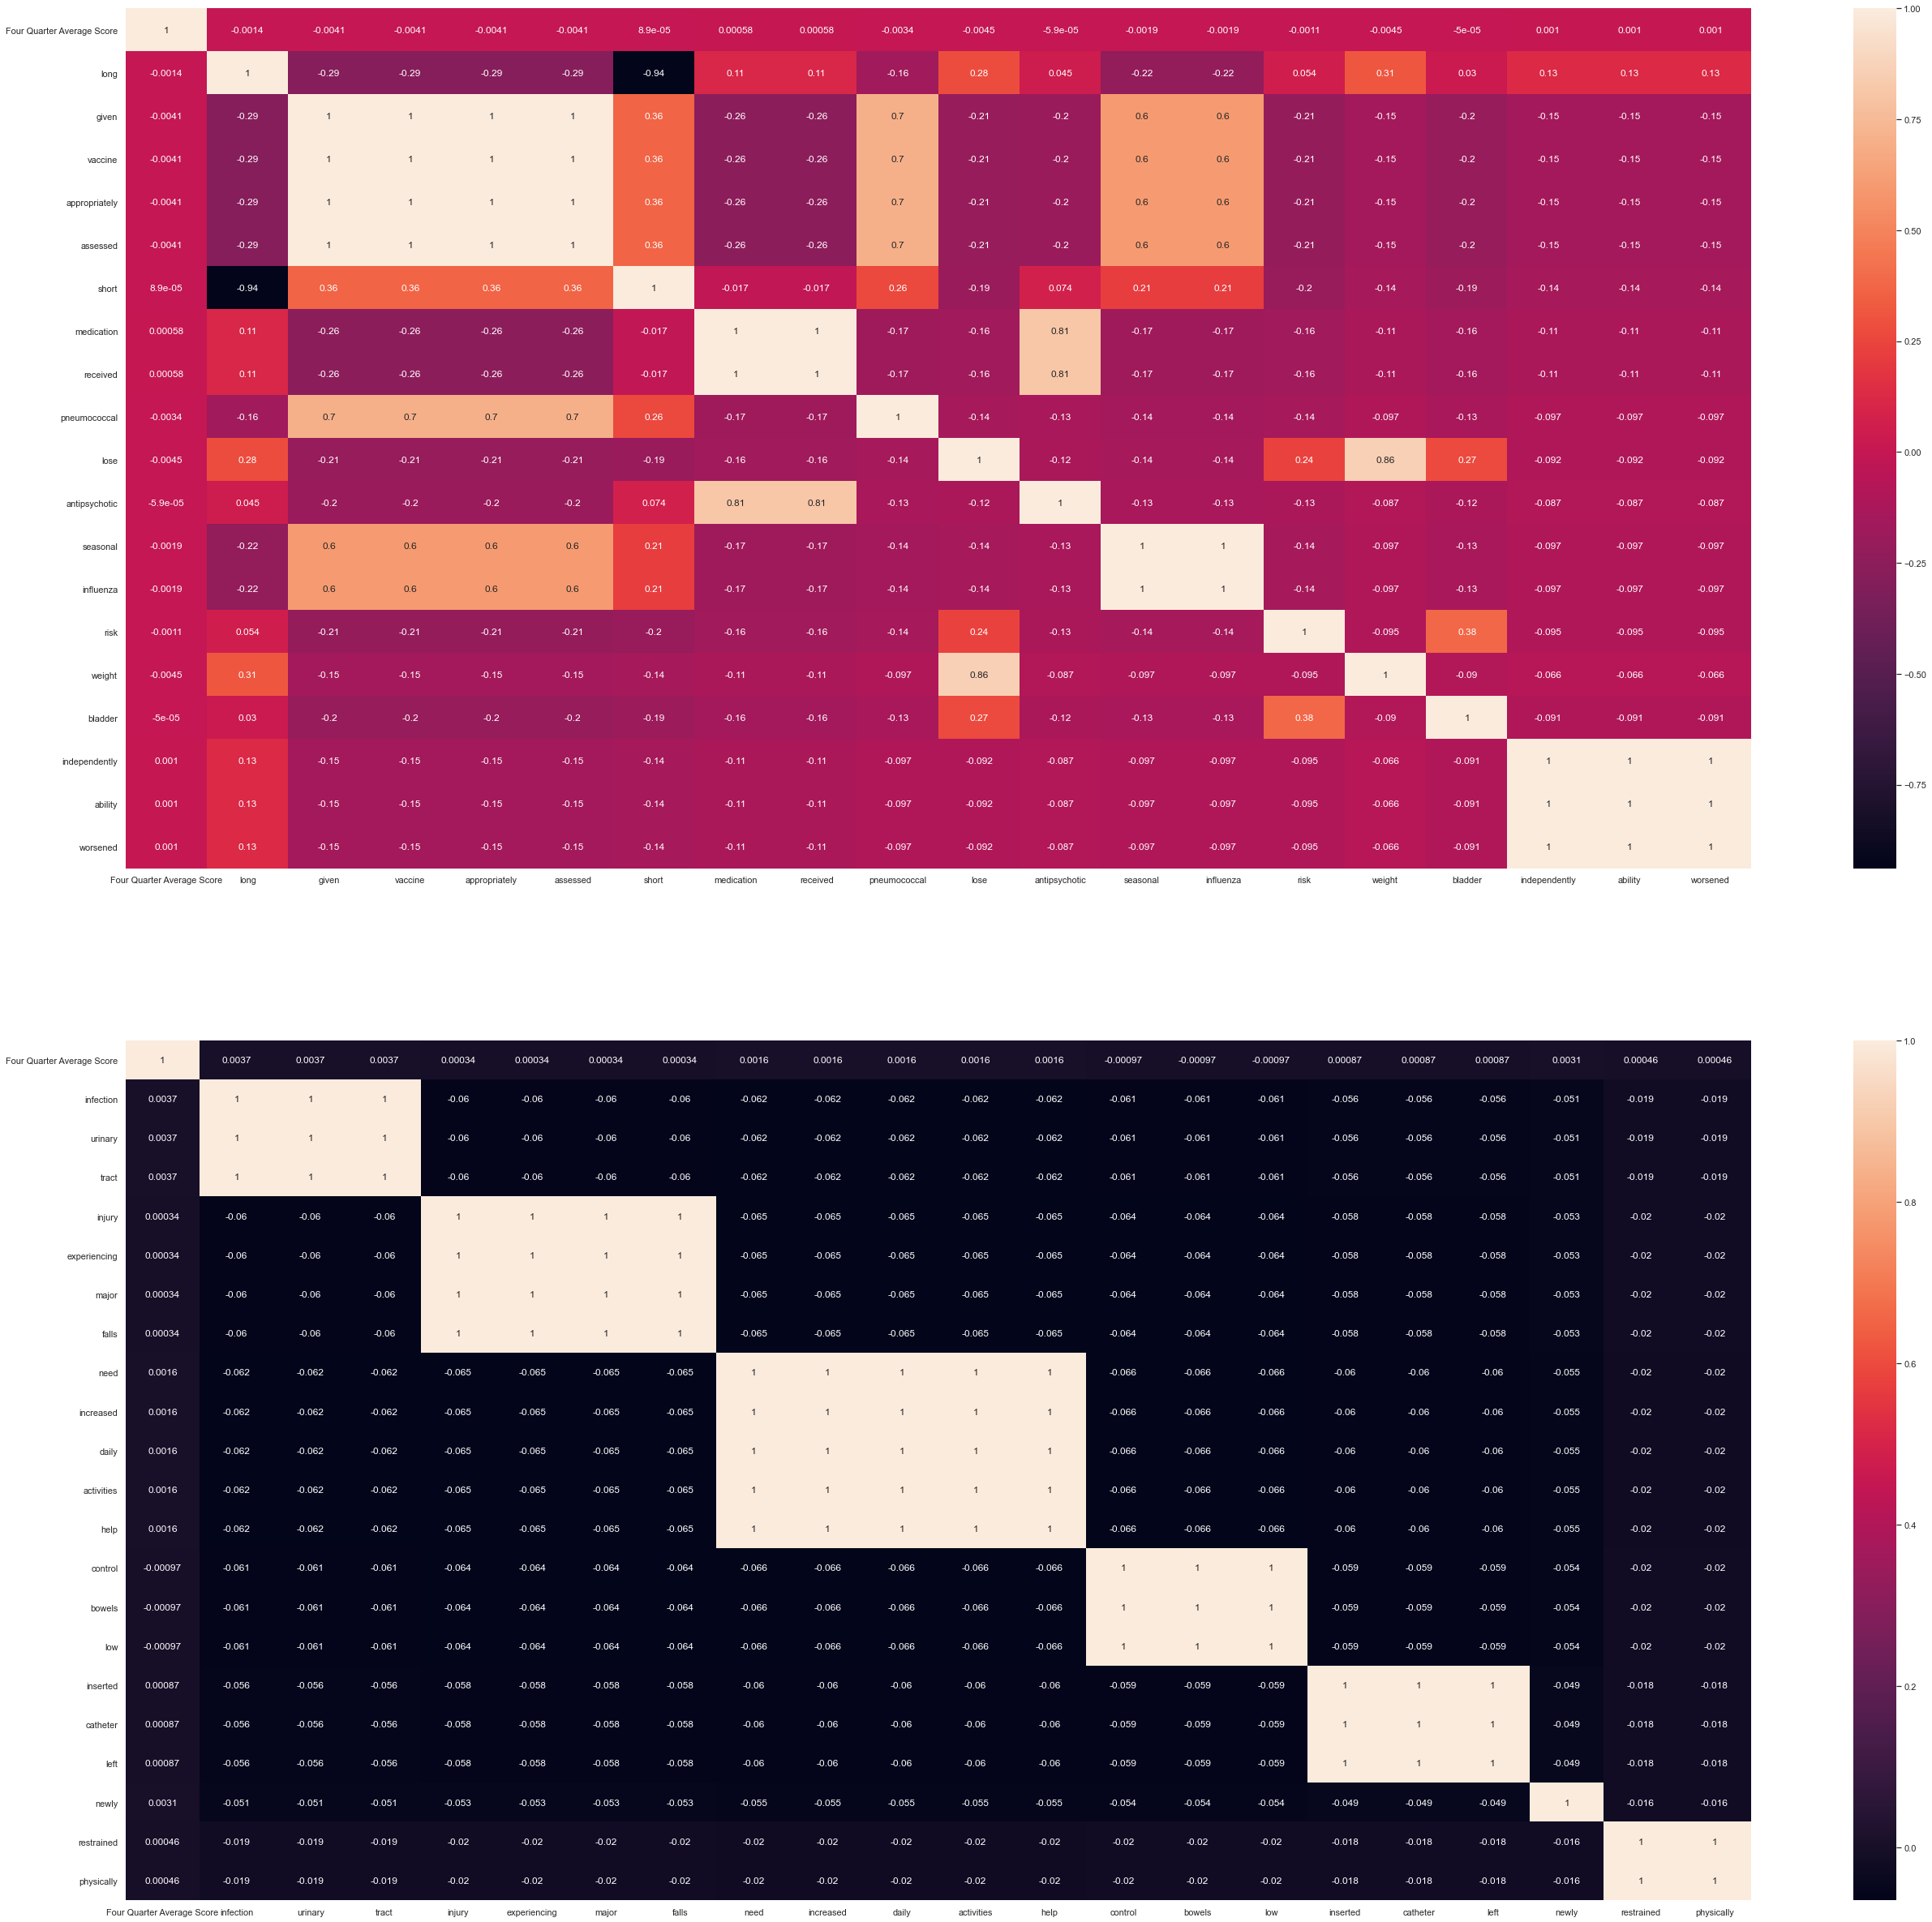

In [120]:
# Make a heatmaps of the Average Score with Texts
fig, ax = plt.subplots(2,1, figsize=(40,40))
sns.heatmap(ax=ax[0], data = cleaned_q[top_words].corr(), annot=True)
sns.heatmap(ax=ax[1], data = cleaned_q[bottom_words].corr(), annot=True)
plt.show()

In [121]:
cleaned_q.to_csv('TFIDF')

When the columns are sorted based on how frequent words appear in text, there are 20 most frequently used words calculated by Pearson Product-Moment Correlation Coefficient. As indicated by above, the words below 14th rank have weaker linkage with `Four Quarter Average Score`. The first plot is based on 20 most frequently used words while the second plot is based on 20 less frequently used words.

In [122]:
# Complete assessment of Pearson Correlation Coefficient
name_columns = list(cleaned_q.columns)

# Create the correlation coefficients between Four Quarter Average Score and all other variables
thelist = {}
for i in enumerate(name_columns):
    thelist[i[1]] = [np.corrcoef(x = cleaned_q['Four Quarter Average Score'],
                      y = cleaned_q[i[1]])[0][1]]

# Coerce dictionary list into dataframe and remove first row where correlation coefficeint = 1
df = pd.DataFrame(thelist).iloc[:,1:].T.rename(columns = {0:'Four Quarter Average Score'}).sort_values(
    'Four Quarter Average Score',ascending = False)

# Limit correlation coefficient to higher than 0.002 or lower than -0.002
df = df[(df['Four Quarter Average Score'] > 0.002) |  (df['Four Quarter Average Score'] < -0.002)]

display(df.style.background_gradient(cmap="Reds"))

,Four Quarter Average Score
urinary,0.003714
tract,0.003714
infection,0.003714
newly,0.003075
improvements,0.002424
function,0.002424
depressive,0.002167
symptoms,0.002167
pneumococcal,-0.003401
assessed,-0.004080


In [123]:
# Select all columns that pearson score is greater than |0.002|
selected_columns = ['Four Quarter Average Score']+list(df.index)
cleaned_q = cleaned_q[selected_columns]

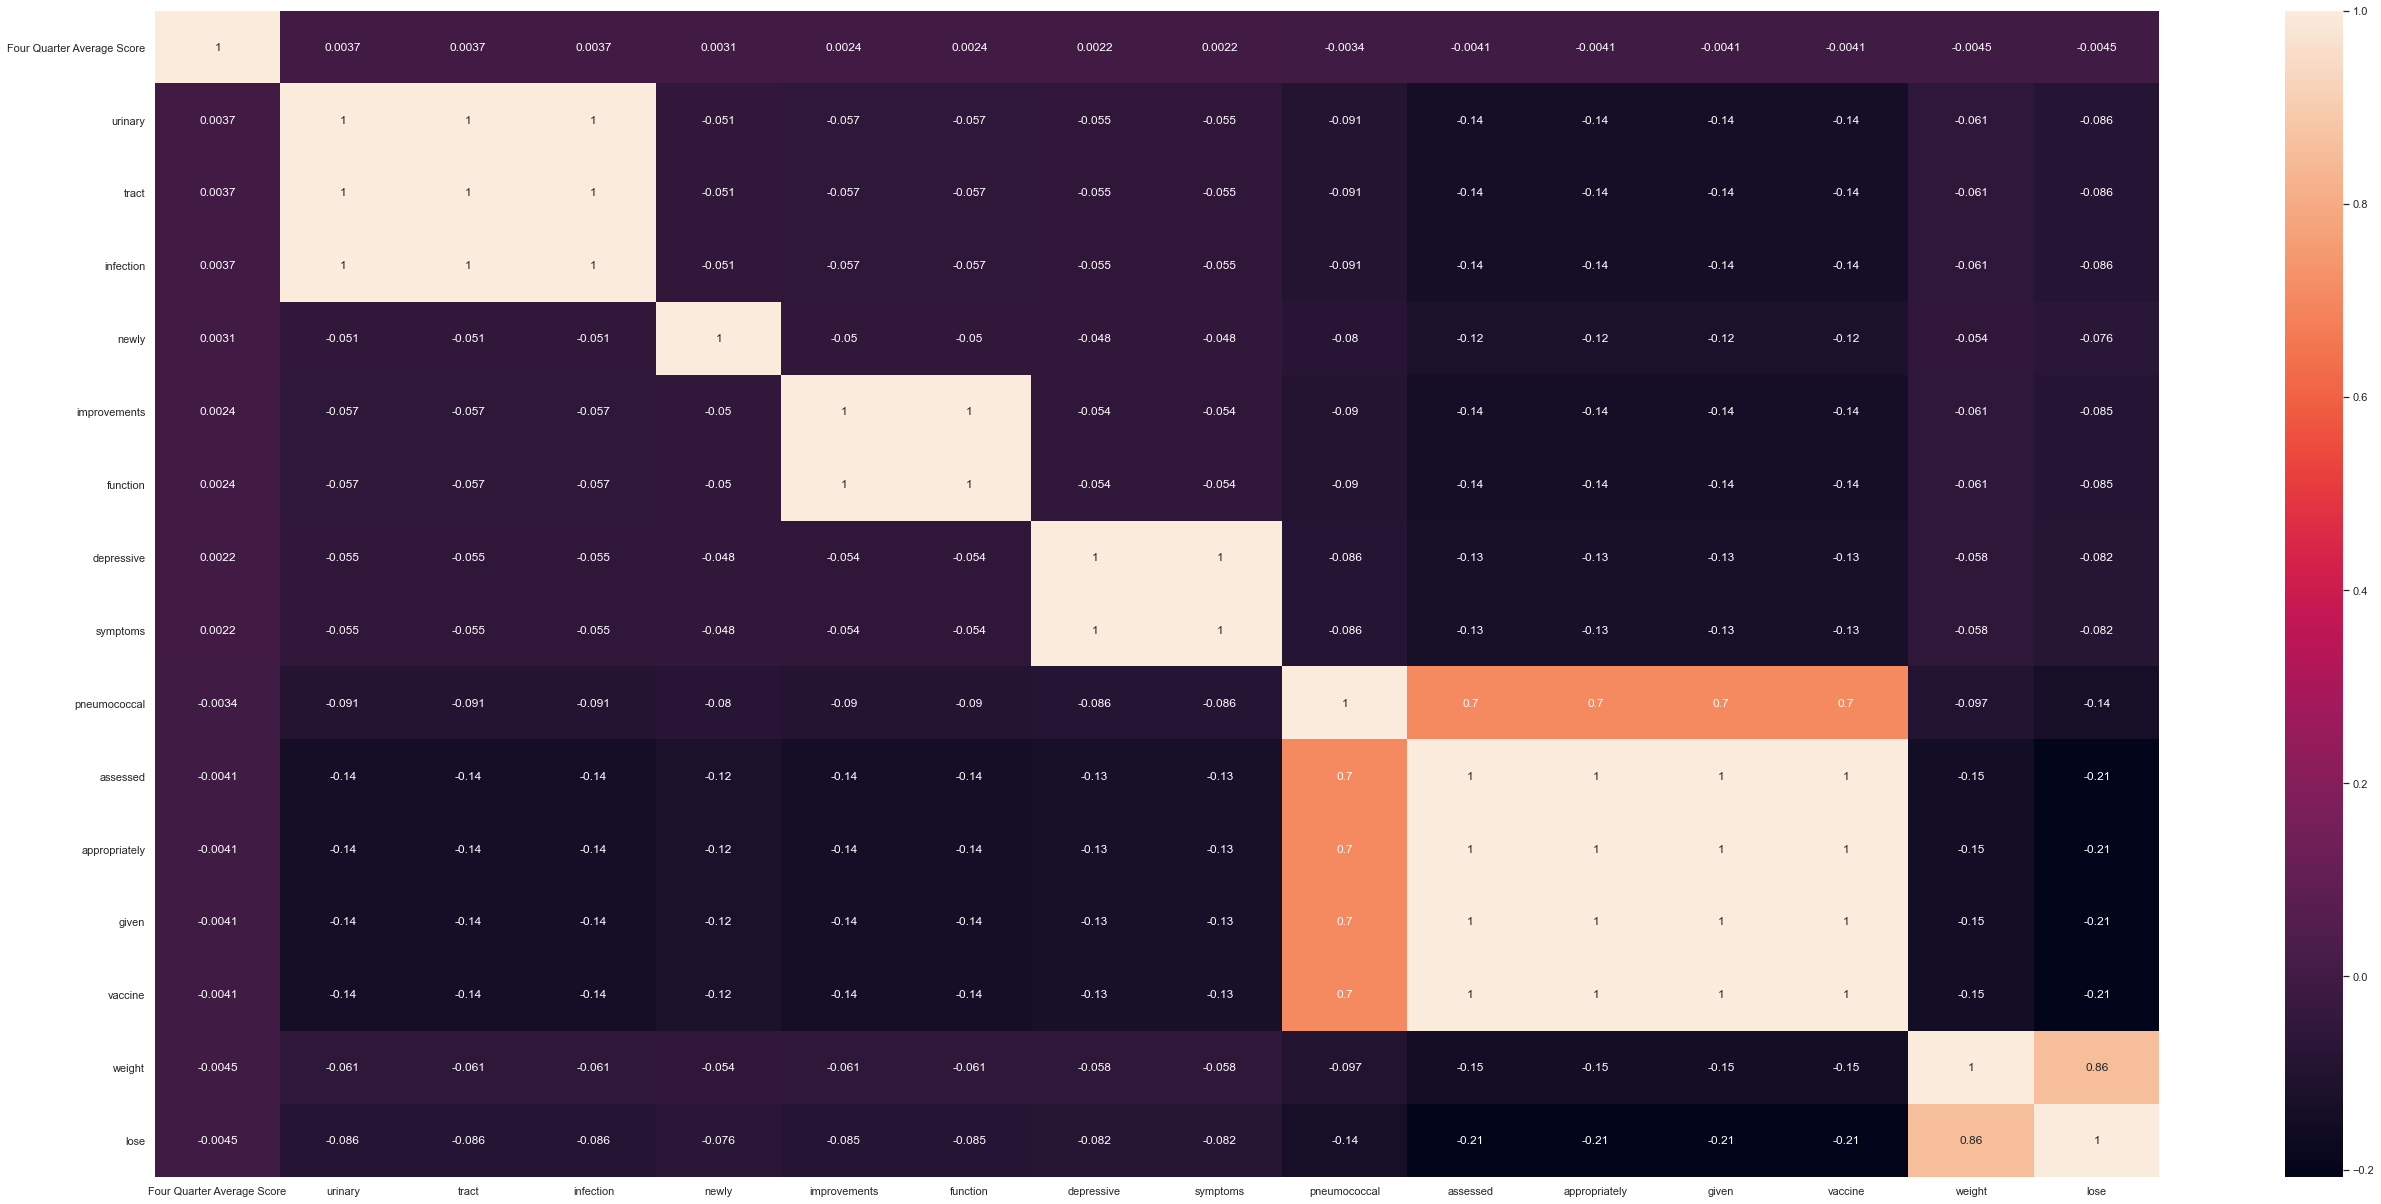

In [124]:
# Make a heatmaps of the Average Score with Texts
plt.subplots(figsize=(40,20))
sns.heatmap(cleaned_q.corr(), annot=True)
plt.show()

There is redundacy in words that are identified, as follow:
- (urinary, tract, infection) = 1 corr coef 
- (function, improvement) = 1 corr coef
- (depression, symptom) = 1 corr coef
- (pneumococcal, assessed, appropriately, given, vaccine) = 0.7 corr coef
- (lose, weight) = 0.86 corr coef

Thus, the words are removed:
- urinary
- tract
- function
- symptom
- assessed
- appropriately
- given
- vaccine
- lose

In [125]:
# Remove redundacy
redundacy = ['urinary','tract','function','symptom','assessed','appropriately','given','vaccine','lose']
df = df[~(df.index.isin(redundacy))]

# Select all columns with no redundacy
selected_columns = ['Four Quarter Average Score']+list(df.index)
cleaned_q = cleaned_q[selected_columns]

display(cleaned_q.head())

,Four Quarter Average Score,infection,newly,improvements,depressive,symptoms,pneumococcal,weight
0,16.993465,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
1,9.154929,0.000000,0.0,0.0,0.0,0.0,0.0,0.749749
2,46.666669,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
3,1.494553,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.636942,0.567728,0.0,0.0,0.0,0.0,0.0,0.000000


### Empirical Cumulative Distribution Function <a id='ecdf'></a>

In [126]:
# Write the ECDF function
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1,n+1)/n
    return x, y

In [127]:
# ECDF all Four Quarter Average Score and Q1-Q4 Score
xq, yq = ecdf(q['Four Quarter Average Score']/100)
xq1, yq1 = ecdf(q1['Q1 Measure Score']/100)
xq2, yq2 = ecdf(q1['Q1 Measure Score']/100)
xq3, yq3 = ecdf(q1['Q1 Measure Score']/100)
xq4, yq4 = ecdf(q1['Q1 Measure Score']/100)

Given that the limited dependent variable is ∈(0,1) and cross-sectional, the continuous version of Binomial Distribution needs to be in use to determine whether not or the empirical distribution is non-parametric. This continuous version is called Beta Distribution. The bootstrapping versions of formulas are in use for the scenario where expected value and variance are known but $\alpha$ and $\beta$ are unknown (Sinharay, 2010).

The bootstrapping versions of formulas are similar to:

$\hat\alpha = \bar x \left[\frac{\bar x (1- \bar x)}{s^2 - 1}\right]$

$\hat\beta = (1- \bar x) \left[ \frac{\bar x (1- \bar x)}{s^2-1} \right]$

### Reference:

-------

Sinharay, S. (2010). The International Encyclopedia of Education. In P. Penelope, E. Baker, & B. McGaw (Eds). *Continuous Probability Distribution* (3rd ed., pp. 98 - 102). Elsevier. https://doi.org/10.1016/B978-0-08-044894-7.01720-6 

--------------

In [128]:
## Create function to calculate alpha and beta
def alpha(data):
    # Mean and Variance
    x = np.mean(data)
    s2 = np.var(data,ddof=1)
    # Alpha
    alpha = np.abs(x*(x*(1-x)/(s2-1)))
    return alpha

def beta(data):
    # Find mean and var
    x = np.mean(data)
    s2 = np.var(data,ddof=1)
    # Find beta
    beta = np.abs((1-x)*(x*(1-x)/(s2-1)))
    return beta

In [131]:
# Set random seed
np.random.seed(56)

# Create Beta Distributions for one-rounded year score and Q1-Q4 scores
xq_theo, yq_theo = ecdf(np.random.beta(alpha(q['Four Quarter Average Score']/100),
               beta(q['Four Quarter Average Score']/100),size=100000))
xq1_theo, yq1_theo = ecdf(np.random.beta(alpha(q1['Q1 Measure Score']/100),
               beta(q1['Q1 Measure Score']/100),size=100000))
xq2_theo, yq2_theo = ecdf(np.random.beta(alpha(q2['Q2 Measure Score']/100),
               beta(q2['Q2 Measure Score']/100),size=100000))
xq3_theo, yq3_theo = ecdf(np.random.beta(alpha(q3['Q3 Measure Score']/100),
               beta(q['Q3 Measure Score']/100),size=100000))
xq4_theo, yq4_theo = ecdf(np.random.beta(alpha(q4['Q4 Measure Score']/100),
               beta(q4['Q4 Measure Score']/100),size=100000))

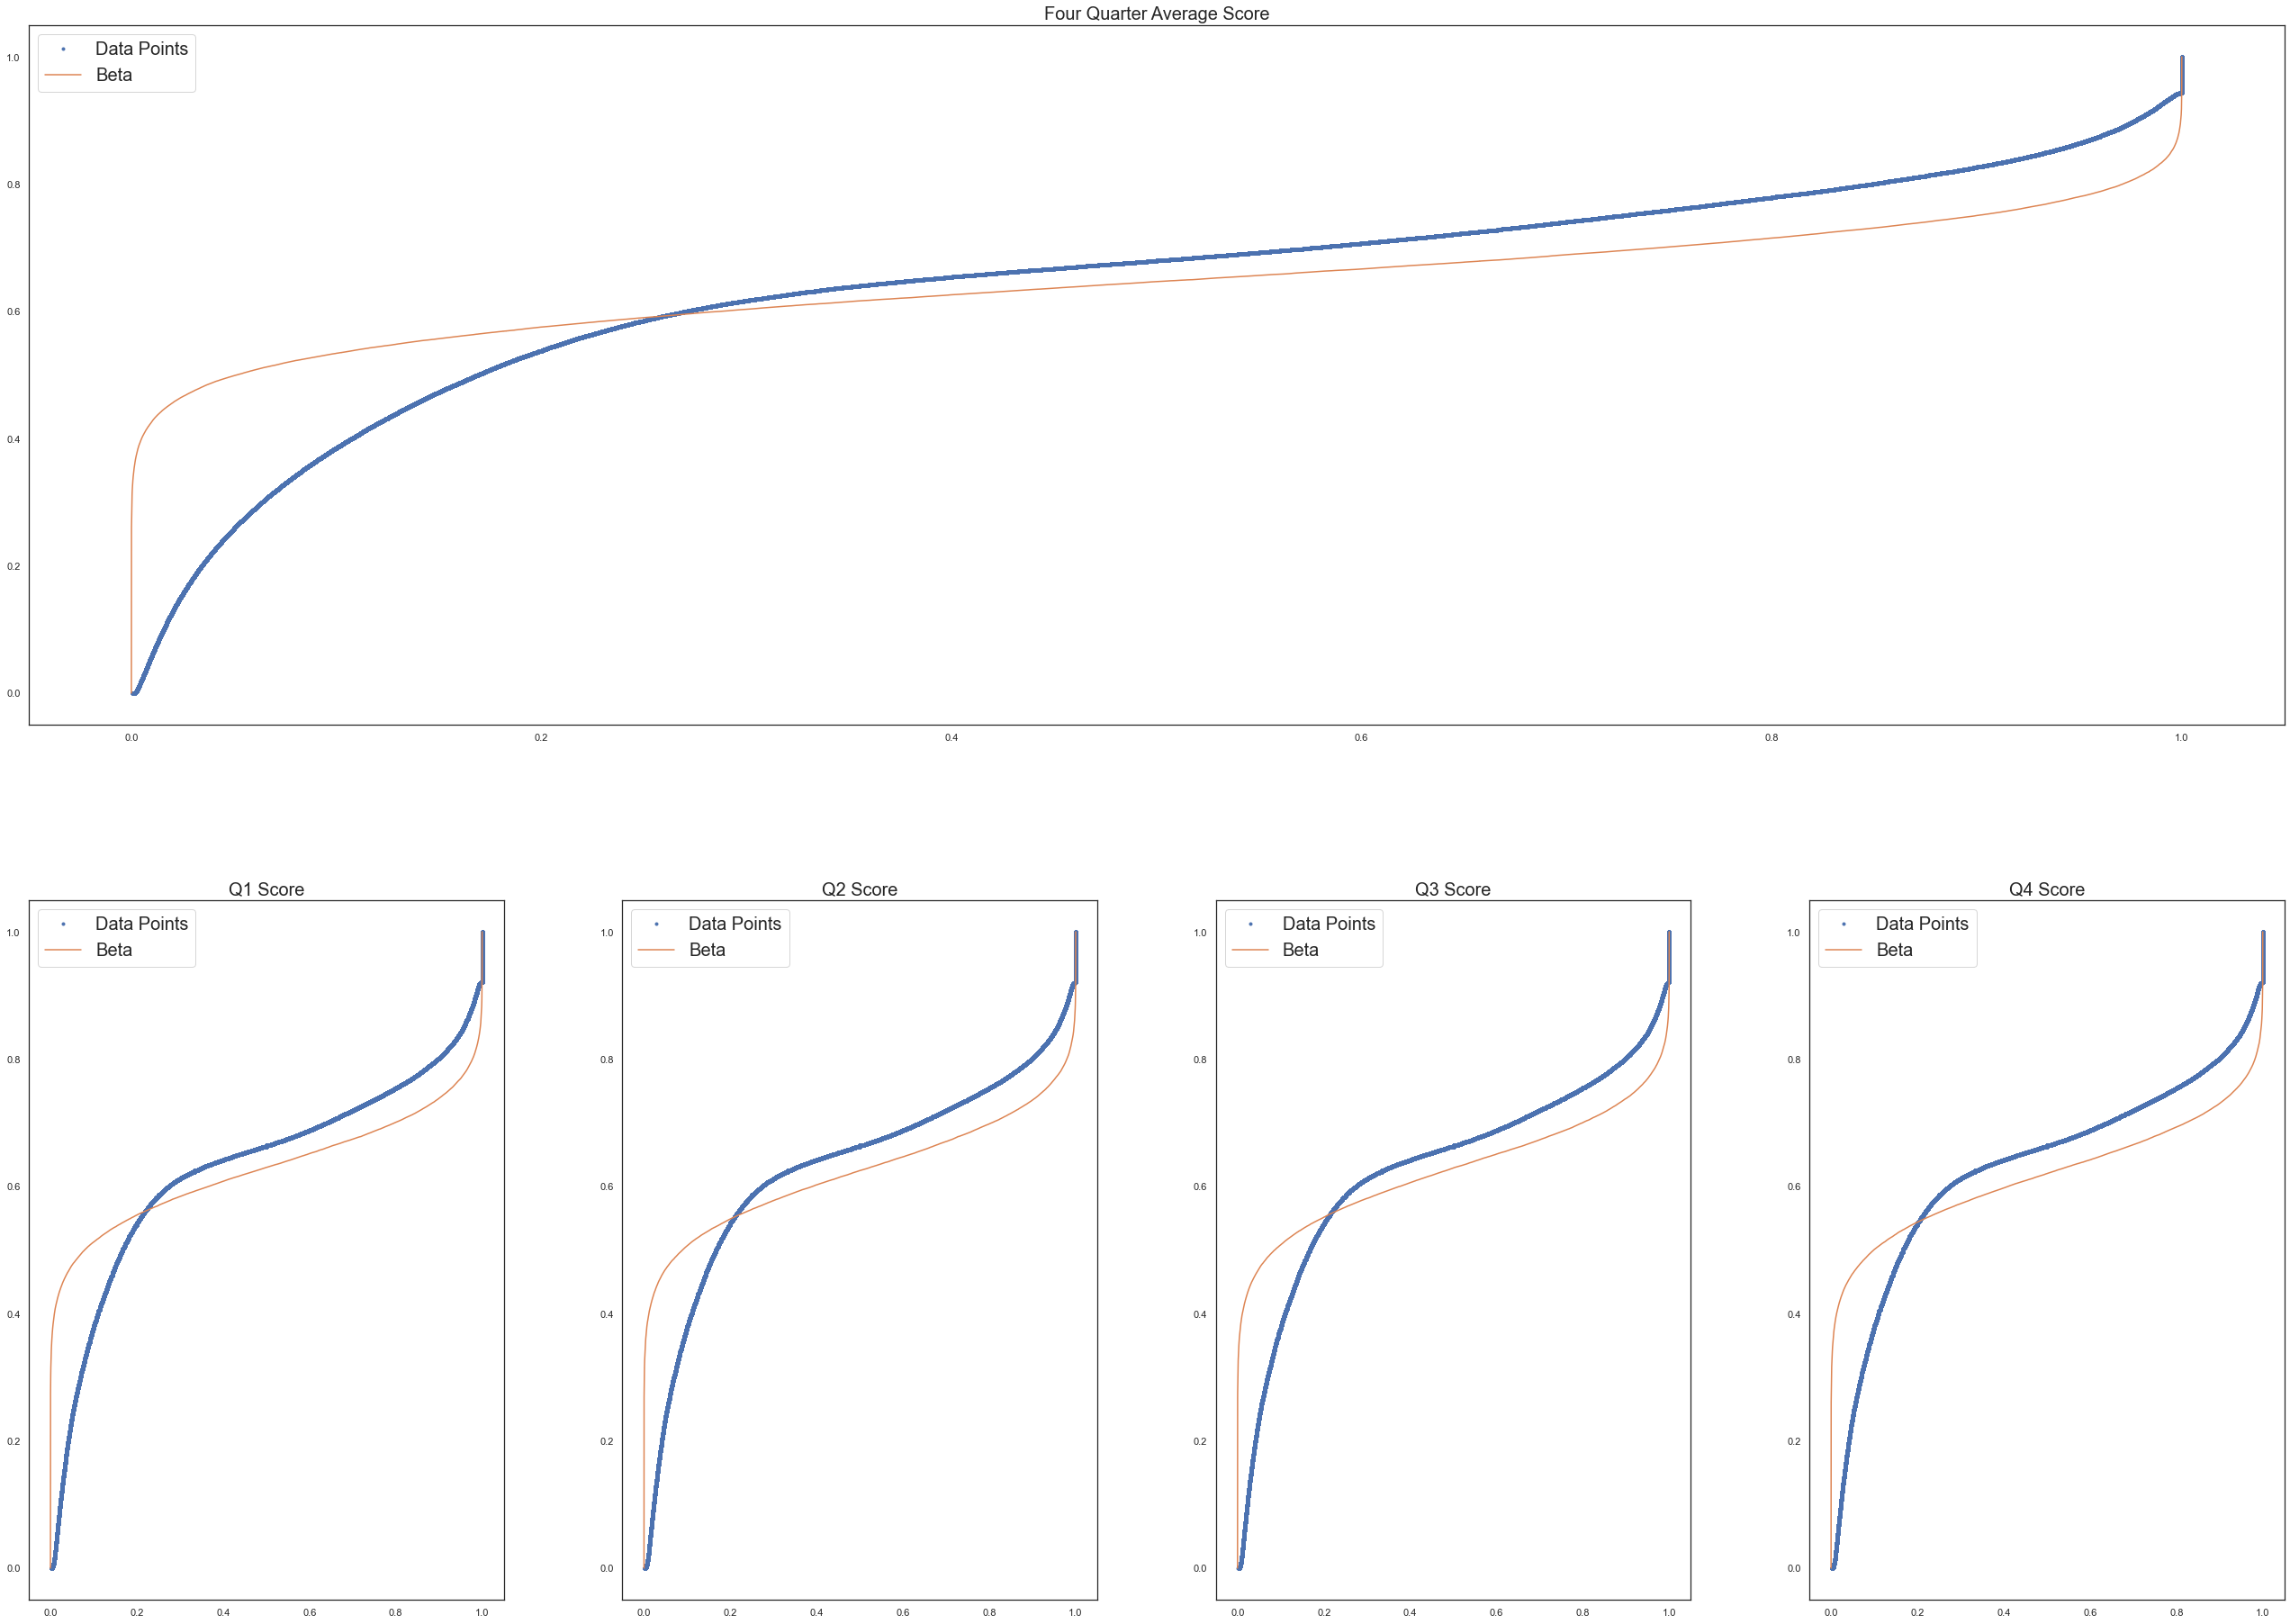

In [132]:
fig = plt.figure(figsize=(40, 30))

rows = 2
columns = 4

grid = plt.GridSpec(rows, columns, wspace = .25, hspace = .25)

plt.subplot(grid[0, :])
plt.plot(xq,yq,marker = '.',linestyle = 'none')
plt.plot(xq_theo,yq_theo)
plt.title('Four Quarter Average Score',fontsize=20)
plt.legend(('Data Points','Beta'),fontsize=20)

plt.subplot(grid[1, 0])
plt.plot(xq1,yq1,marker = '.',linestyle = 'none')
plt.plot(xq1_theo,yq1_theo)
plt.title('Q1 Score',fontsize = 20)
plt.legend(('Data Points','Beta'),fontsize = 20)

plt.subplot(grid[1, 1])
plt.plot(xq2,yq2,marker = '.',linestyle = 'none')
plt.plot(xq2_theo,yq2_theo)
plt.title('Q2 Score',fontsize = 20)
plt.legend(('Data Points','Beta'),fontsize = 20)

plt.subplot(grid[1, 2])
plt.plot(xq3,yq3,marker = '.',linestyle = 'none')
plt.plot(xq3_theo,yq3_theo)
plt.title('Q3 Score',fontsize = 20)
plt.legend(('Data Points','Beta'),fontsize = 20)

plt.subplot(grid[1, 3])
plt.plot(xq4,yq4,marker = '.',linestyle = 'none')
plt.plot(xq4_theo,yq4_theo)
plt.title('Q4 Score',fontsize = 20)
plt.legend(('Data Points','Beta'),fontsize = 20)

plt.show()

When the alpha and beta are parameterized, the theoretical beta cumulative distribution is inconsistent with not only `Four Quarter Average Score` ECDF but all Q1-Q4 ECDFs. In other words, the area between curves is higher than zero due to wide gap between empirical and theoretical distributions. In other words, the non-parameteric procedure test called permutation test needs to be in use in order to test several hypotheses. For causal analysis, the non-parametric regression should be in use.

### Permutation Test: Score With 'pneumococcal' and Without 'pneumococcal' <a id='hypothesis'></a>

In [133]:
def permutation_test(data, target_column = 'score', separate_by = 'column', separate_value = 0, size = 10000):
    # Observed difference
    observed_diff = np.mean(data[data[separate_by] == separate_value][target_column]) - np.mean(data[
        data[separate_by] != separate_value][target_column])
    # Instantiate the list and permutation loop
    diff = []
    for i in range(size):
        perm_result = np.random.RandomState(seed = i+1).permutation(data[target_column])
        diff.append(np.mean(perm_result[data[separate_by] == separate_value])-np.mean(
            perm_result[data[separate_by] != separate_value]))
    
    # Find the p-value where random difference is equal to or larger than observed difference
    pvalue = np.sum(np.abs(diff) >= np.abs(observed_diff))/len(data)
    
    return pvalue

In [135]:
cleaned_q.columns

Index(['Four Quarter Average Score', 'infection', 'newly', 'improvements',
       'depressive', 'symptoms', 'pneumococcal', 'weight'],
      dtype='object')

In [144]:
p_values = {}
for i in ['long','short','medication','received','pneumococcal']:
    perm_test = forperm[['Four Quarter Average Score', i]]
    perm_test[i] = perm_test[i].apply(lambda x: 0 if x == 0 else 1)
    p_value = permutation_test(perm_test, target_column = 'Four Quarter Average Score', 
                 separate_by = i, separate_value = 0, size = 1000)
    p_values[i] = [p_value]

<ipython-input-144-92c18d2ddda1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perm_test[i] = perm_test[i].apply(lambda x: 0 if x == 0 else 1)
<ipython-input-144-92c18d2ddda1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perm_test[i] = perm_test[i].apply(lambda x: 0 if x == 0 else 1)
<ipython-input-144-92c18d2ddda1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [147]:
display(pd.DataFrame(p_values).T.rename(columns={0:'p-value'}))

,p-value
long,0.004713
short,0.004713
medication,0.002978
received,0.002978
pneumococcal,0.000679
